In [14]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import math

In [15]:
#Function to draw cube
def draw_cube(ax, origin, size, color='skyblue', alpha=0.6):
    """Draws a cube at a given origin with a given size"""
    x, y, z = origin
    dx, dy, dz = size
    # Define the 8 vertices of the cube
    vertices = [
        [x, y, z],
        [x + dx, y, z],
        [x + dx, y + dy, z],
        [x, y + dy, z],
        [x, y, z + dz],
        [x + dx, y, z + dz],
        [x + dx, y + dy, z + dz],
        [x, y + dy, z + dz]
    ]
    # Define the 6 faces
    faces = [
        [vertices[0], vertices[1], vertices[2], vertices[3]],
        [vertices[4], vertices[5], vertices[6], vertices[7]],
        [vertices[0], vertices[1], vertices[5], vertices[4]],
        [vertices[2], vertices[3], vertices[7], vertices[6]],
        [vertices[1], vertices[2], vertices[6], vertices[5]],
        [vertices[4], vertices[7], vertices[3], vertices[0]]
    ]
    ax.add_collection3d(Poly3DCollection(faces, facecolors=color, edgecolors='k', linewidths=0.2, alpha=alpha))

In [16]:
#Line to line minimum distance function
def line_to_line_distance(p1, p2, q1, q2):
    """Returns shortest distance between two line segments p1-p2 and q1-q2"""
    u = p2 - p1
    v = q2 - q1
    w = p1 - q1
    a = np.dot(u, u)
    b = np.dot(u, v)
    c = np.dot(v, v)
    d = np.dot(u, w)
    e = np.dot(v, w)
    D = a * c - b * b
    sc, sN, sD = D, D, D
    tc, tN, tD = D, D, D

    SMALL_NUM = 1e-8

    if D < SMALL_NUM:
        sN = 0.0
        sD = 1.0
        tN = e
        tD = c
    else:
        sN = (b * e - c * d)
        tN = (a * e - b * d)
        if sN < 0.0:
            sN = 0.0
            tN = e
            tD = c
        elif sN > sD:
            sN = sD
            tN = e + b
            tD = c

    if tN < 0.0:
        tN = 0.0
        if -d < 0.0:
            sN = 0.0
        elif -d > a:
            sN = sD
        else:
            sN = -d
            sD = a
    elif tN > tD:
        tN = tD
        if (-d + b) < 0.0:
            sN = 0
        elif (-d + b) > a:
            sN = sD
        else:
            sN = (-d + b)
            sD = a

    sc = 0.0 if abs(sN) < SMALL_NUM else sN / sD
    tc = 0.0 if abs(tN) < SMALL_NUM else tN / tD

    dP = w + sc * u - tc * v
    return np.linalg.norm(dP)


In [85]:
 def distance_cneter_point_to_line(point, line_start, line_end):
    """Returns shortest distance from a point to a line segment"""
    point = np.array(point)
    line = line_end - line_start
    line_mag = np.linalg.norm(line)
    if line_mag == 0:
        return np.linalg.norm(point - line_start)
    proj = np.dot(point - line_start, line) / line_mag
    if proj < 0:
        closest = line_start
    elif proj > line_mag:
        closest = line_end
    else:
        closest = line_start + (proj / line_mag) * line
    return np.linalg.norm(point - closest)

In [86]:
def top_point_to_line_distance(point, line_start, line_end):
    """Shortest distance from a point to a line segment in 3D"""
    point = np.array(point)
    line_vec = line_end - line_start
    point_vec = point - line_start
    line_len = np.linalg.norm(line_vec)
    line_unitvec = line_vec / line_len
    proj_length = np.dot(point_vec, line_unitvec)
    proj_point = line_start + proj_length * line_unitvec

    # Clamp projection point to the segment
    proj_point = np.clip(proj_point, np.minimum(line_start, line_end), np.maximum(line_start, line_end))
    return np.linalg.norm(point - proj_point)

In [128]:
#Station input
pallet_h = 8
dolly_h = 13.97
riser_h = 9

platform_height = 11.8

total_z_height = math.ceil(dolly_h + riser_h + pallet_h)

pick_height = 48 + platform_height

edge_p1 = np.array([pkg_x, 0, pick_height])
edge_p2 = np.array([pkg_x, pkg_y, pick_height])

In [129]:
#Mostly fixed input


In [141]:
#Pkg Input
pkg_x = 48
pkg_y = 45
pkg_z = 45

In [196]:
#Part input

part_l_x = 12
part_w_y = 5
part_h_z = 8
pick = "edge" #or edge

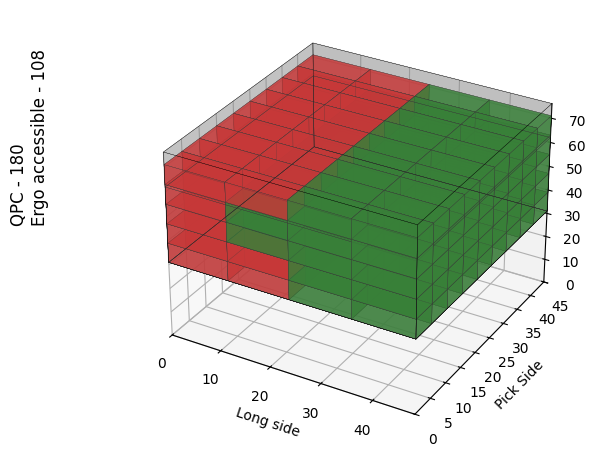

In [210]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
draw_cube(ax,(0,0,total_z_height),(pkg_x,pkg_y,pkg_z), color="grey",alpha=0.25)

#draw pallet + dolly + Riser
draw_cube(ax,(0,0,total_z_height),(pkg_x,pkg_y,total_z_height), color="black",alpha=0.0)


qpc = 0
ergo = 0
max_x = math.floor(pkg_x - part_l_x) if pkg_x % part_l_x !=0 else pkg_x
max_y = math.floor(pkg_y - part_w_y) if pkg_y % part_w_y !=0 else pkg_y
max_z = math.floor(pkg_z - part_h_z) if pkg_z % part_h_z !=0 else pkg_z

for x in range(0, max_x, part_l_x):
    for y in range(0, max_y,part_w_y):
        for z in range(total_z_height, max_z+total_z_height, part_h_z): 

            if pick == "center":
                # Center of mini-cube
                cx = x + part_l_x / 2
                cy = y + part_w_y / 2
                cz = z + part_h_z / 2
                dist = distance_cneter_point_to_line([cx, cy, cz], edge_p1, edge_p2)
            elif pick == "top center":
                # Top surface center of this mini-cube
                top_center = np.array([x + part_l_x/2, y + part_w_y/2, z + part_h_z])
                 # Distance to main cube's top-right vertical edge
                dist = top_point_to_line_distance(top_center, edge_p1, edge_p2)
            else:
                local_edge_p1 = np.array([x + part_l_x, part_w_y, z + part_h_z])
                local_edge_p2 = np.array([x + part_l_x, y + part_w_y, z + part_h_z])
                dist = line_to_line_distance(local_edge_p1, local_edge_p2, edge_p1, edge_p2)
            
            color = 'green' if dist < 25 else 'red'
            draw_cube(ax, (x, y, z), (part_l_x, part_w_y, part_h_z), color = color)
            if color == 'green':
                ergo = ergo + 1
            qpc = qpc + 1
            

fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.05)            
fig.text(
    0.01,     # x-position (close to left edge)
    0.5,      # y-position (middle of figure vertically)
    "QPC - " + str(qpc) + "\n" + "Ergo accessible - " + str(ergo) + "",  # your message
    va='bottom',
    ha='left',
    fontsize=12,
    color='black',
    rotation=90  # Optional: vertical text
)            
           

ax.set_xlim(0, pkg_x)
ax.set_ylim(0, pkg_y)
ax.set_zlim(0,pkg_z+total_z_height)
ax.set_xlabel("Long side")
ax.set_ylabel('Pick Side')
ax.set_zlabel('Z')
#plt.tight_layout()


plt.show()